In [1]:
import astropy.units as u
import numpy as np
from astroquery.simbad import Simbad
import astropy.coordinates as coord

from astropy.io import ascii
from astropy.io import fits
import os.path
# 
import elk
from elk.ensemble import EnsembleLC
from elk.lightcurve import BasicLightcurve

from astropy.table import Table, join, MaskedColumn, vstack, Column
from matplotlib import pyplot as plt


path = '/uufs/chpc.utah.edu/common/home/astro/zasowski/sinha/fits/'
plt.style.use(path +'paper_style.mplstyle')
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams['text.usetex'] = True

In [2]:
cluster_summary_stats = Table.read('cluster_summary_statistics.fits')

In [3]:
age_path = '/uufs/chpc.utah.edu/common/home/astro/zasowski/sinha/tess_data/data/'

mw=Table.read(age_path + 'Use_MW.fits')

smc=Table.read(age_path + 'Bica_Cut_down.fits')

lmc=Table.read(age_path + 'Glatt_Cut_down.fits')


In [4]:
ages=[]
location = []
for name in list(cluster_summary_stats['summary_fname']):
    for i in range(len(mw)):
        if mw[i]['NAME']== name:
            ages.append(mw[i]['LOG_AGE'])
            location.append('MW')
    
    for j in range(len(smc)):
        if smc[j]['SimbadName']==name:
            ages.append(smc[j]['logAge'])
            location.append('SMC')
            
    for k in range(len(lmc)):
        if lmc[k]['SimbadName']==name:
            ages.append(lmc[k]['Age'])
            location.append('LMC')
        
cluster_summary_stats['age'] = ages
cluster_summary_stats['location'] = location

# MW

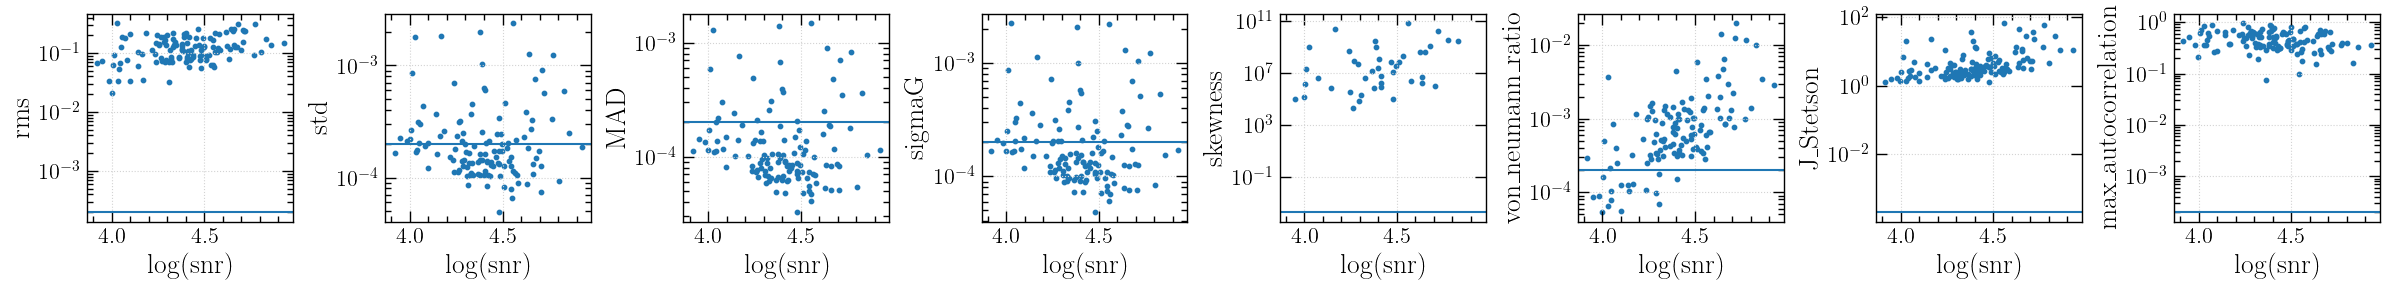

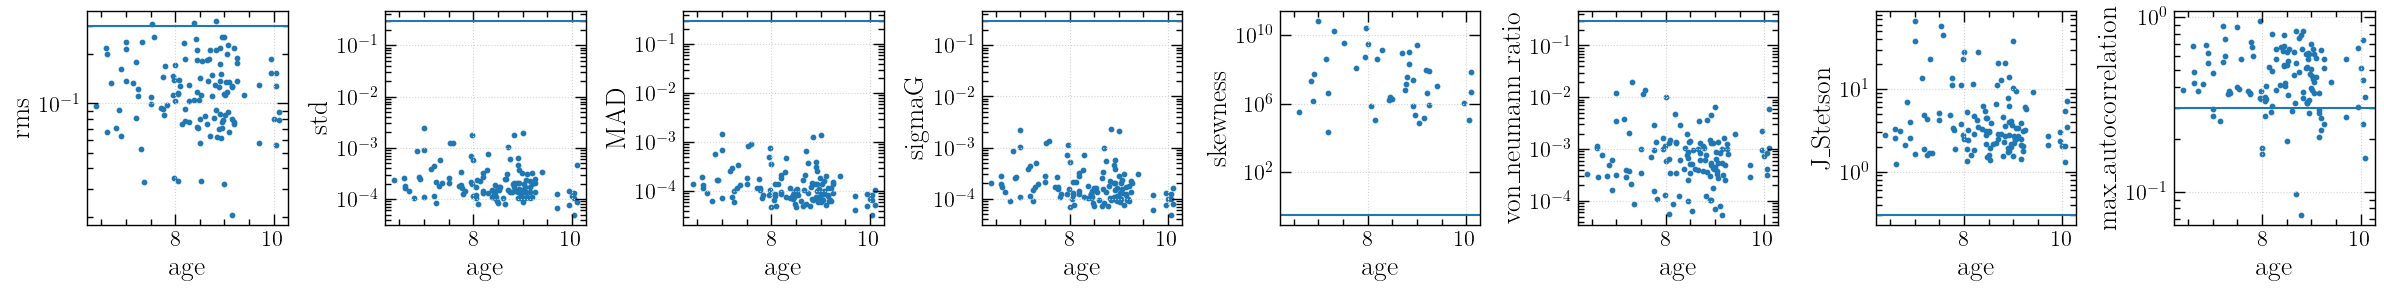

In [34]:
mw_clusters = cluster_summary_stats[cluster_summary_stats['location']=='MW']

stats = ['rms','std','MAD','sigmaG','skewness','von_neumann_ratio','J_Stetson','max_autocorrelation']

#snr
col = 0
fig,ax = plt.subplots(1,8,figsize=(24,3))
for i in stats:
    ax[col].scatter(mw_clusters['snr_50'],mw_clusters['{}_50'.format(i)],s=10)
    ax[col].axhline(y=0.0002)
    ax[col].set_yscale('log')
    ax[col].set_ylabel(i,fontsize=20)
    ax[col].set_xlabel('log(snr)',fontsize=20)
    col +=1
plt.tight_layout()


#age
stats = ['rms','std','MAD','sigmaG','skewness','von_neumann_ratio','J_Stetson','max_autocorrelation']

col = 0
fig,ax = plt.subplots(1,8,figsize=(24,3))
for i in stats:
    ax[col].scatter(mw_clusters['age'],mw_clusters['{}_50'.format(i)],s=10)
    ax[col].axhline(y=0.3)
    ax[col].set_yscale('log')
    ax[col].set_ylabel(i,fontsize=20)
    ax[col].set_xlabel('age',fontsize=20)
    col +=1
plt.tight_layout()

truth = (mw_clusters['std_50'] <=0.0002) & (mw_clusters['max_autocorrelation_50'] >0.3)
mw_clusters['gold_cut'] = truth

# LMC

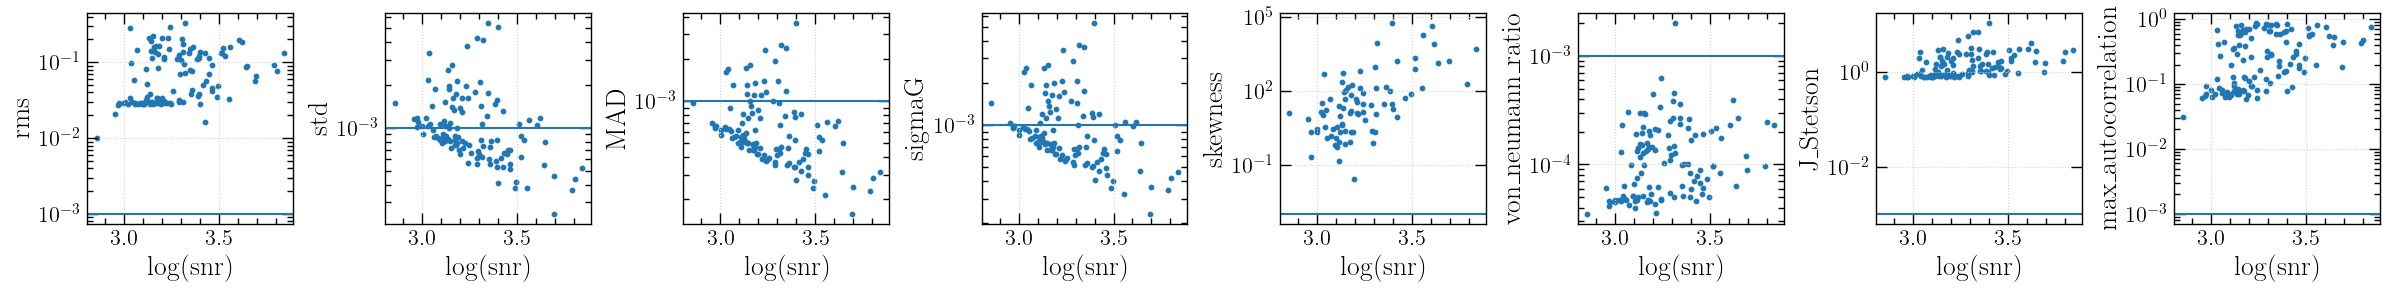

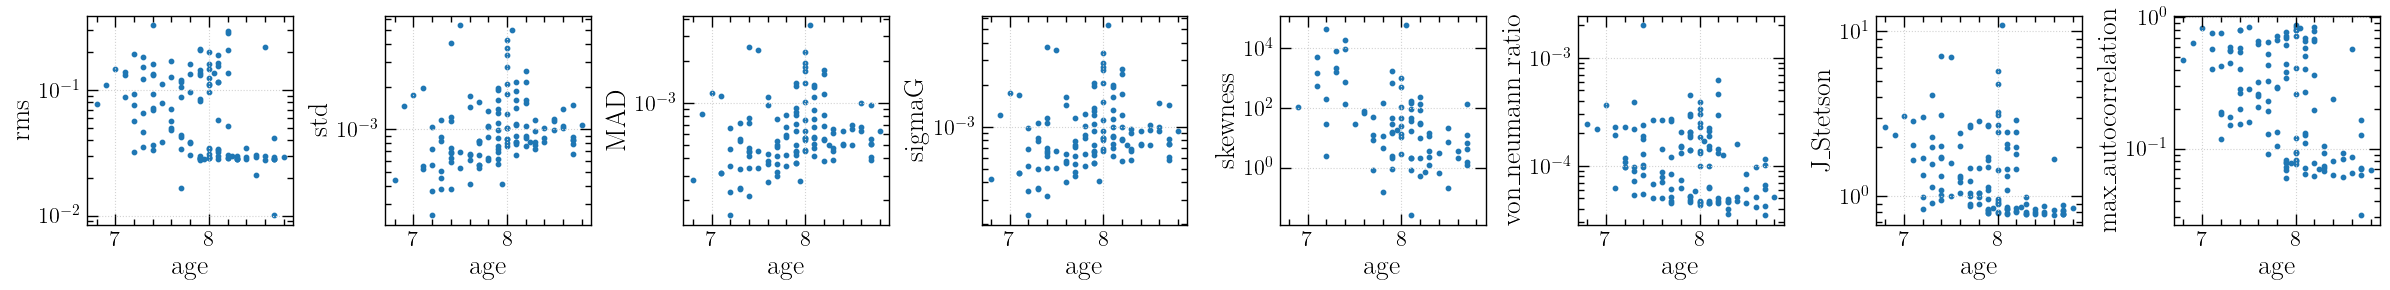

In [35]:
lmc_clusters = cluster_summary_stats[cluster_summary_stats['location']=='LMC']

stats = ['rms','std','MAD','sigmaG','skewness','von_neumann_ratio','J_Stetson','max_autocorrelation']

#snr
col = 0
fig,ax = plt.subplots(1,8,figsize=(24,3))
for i in stats:
    ax[col].scatter(lmc_clusters['snr_50'],lmc_clusters['{}_50'.format(i)],s=10)
    ax[col].axhline(y=0.001)
    ax[col].set_yscale('log')
    ax[col].set_ylabel(i,fontsize=20)
    ax[col].set_xlabel('log(snr)',fontsize=20)
    col +=1
plt.tight_layout()


#age
stats = ['rms','std','MAD','sigmaG','skewness','von_neumann_ratio','J_Stetson','max_autocorrelation']

col = 0
fig,ax = plt.subplots(1,8,figsize=(24,3))
for i in stats:
    ax[col].scatter(lmc_clusters['age'],lmc_clusters['{}_50'.format(i)],s=10)
    ax[col].set_yscale('log')
    ax[col].set_ylabel(i,fontsize=20)
    ax[col].set_xlabel('age',fontsize=20)
    col +=1
plt.tight_layout()

truth = (lmc_clusters['std_50'] <=0.001) & (lmc_clusters['max_autocorrelation_50'] >0.3)
lmc_clusters['gold_cut'] = truth

# SMC

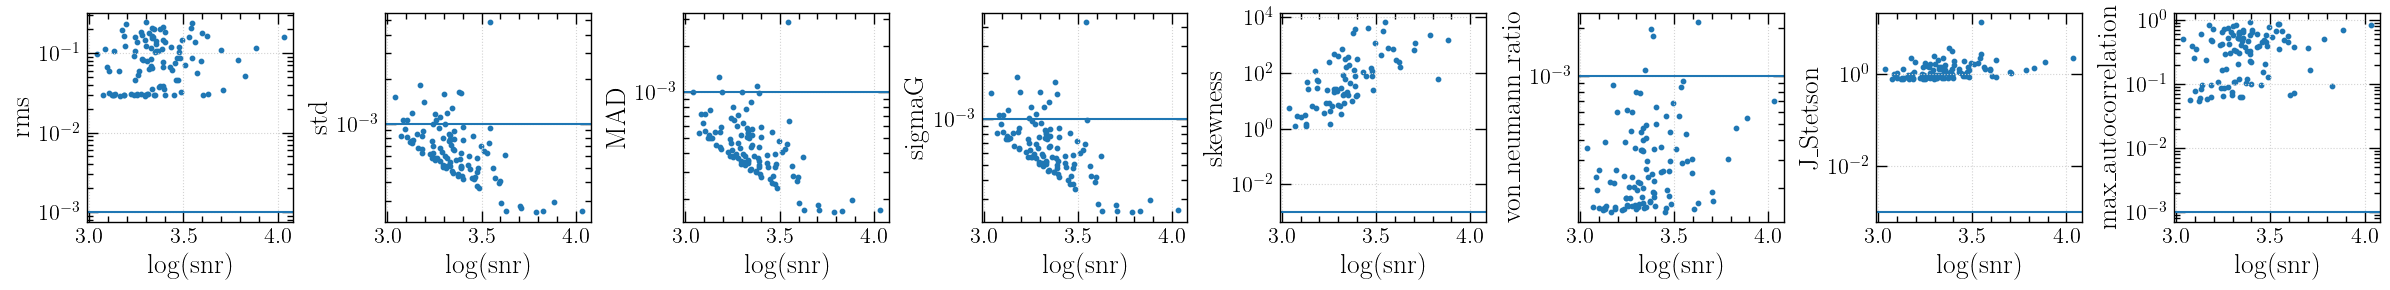

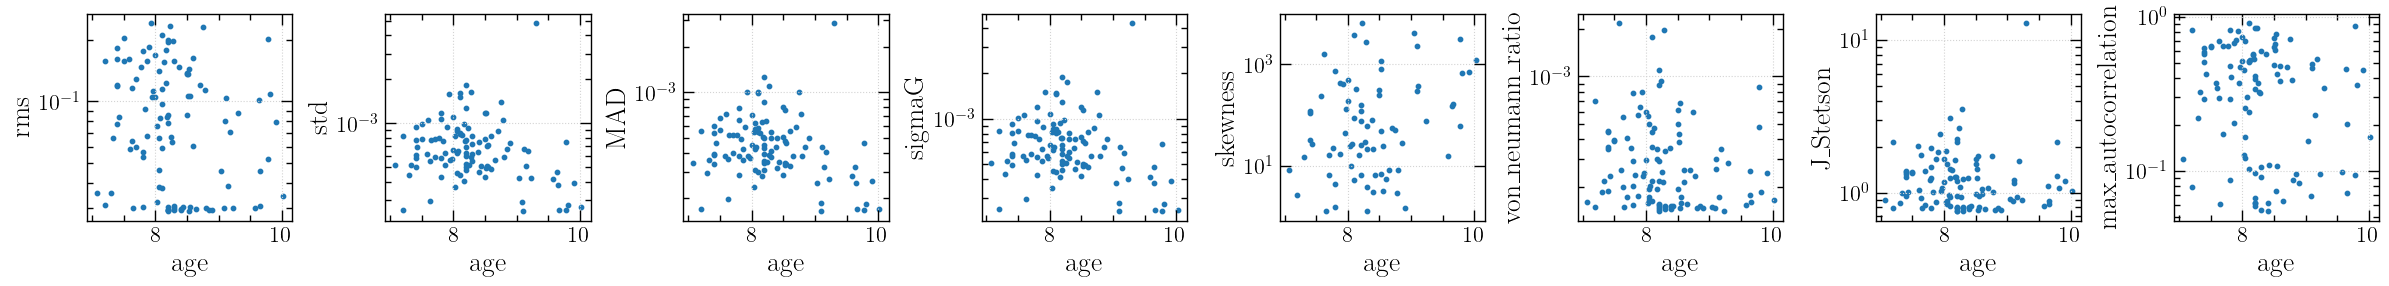

In [36]:
smc_clusters = cluster_summary_stats[cluster_summary_stats['location']=='SMC']

stats = ['rms','std','MAD','sigmaG','skewness','von_neumann_ratio','J_Stetson','max_autocorrelation']

#snr
col = 0
fig,ax = plt.subplots(1,8,figsize=(24,3))
for i in stats:
    ax[col].scatter(smc_clusters['snr_50'],smc_clusters['{}_50'.format(i)],s=10)
    ax[col].axhline(y=0.001)
    ax[col].set_yscale('log')
    ax[col].set_ylabel(i,fontsize=20)
    ax[col].set_xlabel('log(snr)',fontsize=20)
    col +=1
plt.tight_layout()


#age
stats = ['rms','std','MAD','sigmaG','skewness','von_neumann_ratio','J_Stetson','max_autocorrelation']

col = 0
fig,ax = plt.subplots(1,8,figsize=(24,3))
for i in stats:
    ax[col].scatter(smc_clusters['age'],smc_clusters['{}_50'.format(i)],s=10)
    ax[col].set_yscale('log')
    ax[col].set_ylabel(i,fontsize=20)
    ax[col].set_xlabel('age',fontsize=20)
    col +=1
plt.tight_layout()

truth = (smc_clusters['std_50'] <=0.001) & (smc_clusters['max_autocorrelation_50'] >0.3)
smc_clusters['gold_cut'] = truth

In [37]:
smc_gold = smc_clusters[smc_clusters['gold_cut']]
lmc_gold = lmc_clusters[lmc_clusters['gold_cut']]
mw_gold = mw_clusters[mw_clusters['gold_cut']]

gold_sample = vstack([smc_gold,lmc_gold,mw_gold])

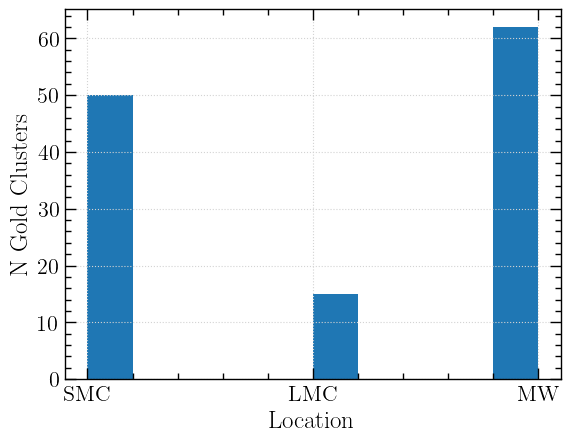

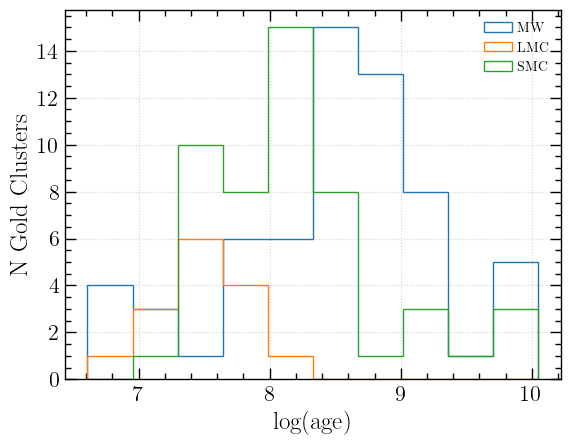

In [38]:
plt.figure()
plt.hist(gold_sample['location'])
plt.ylabel('N Gold Clusters')
plt.xlabel('Location')

bins = np.histogram(np.hstack((mw_gold['age'],lmc_gold['age'],smc_gold['age'])), bins=10)[1] # Get the bin edges

plt.figure()
plt.hist(mw_gold['age'],bins,histtype='step',label='MW')
plt.hist(lmc_gold['age'],bins,histtype='step',label='LMC')
plt.hist(smc_gold['age'],bins,histtype='step',label='SMC')
plt.ylabel('N Gold Clusters')
plt.xlabel('log(age)')
plt.legend()

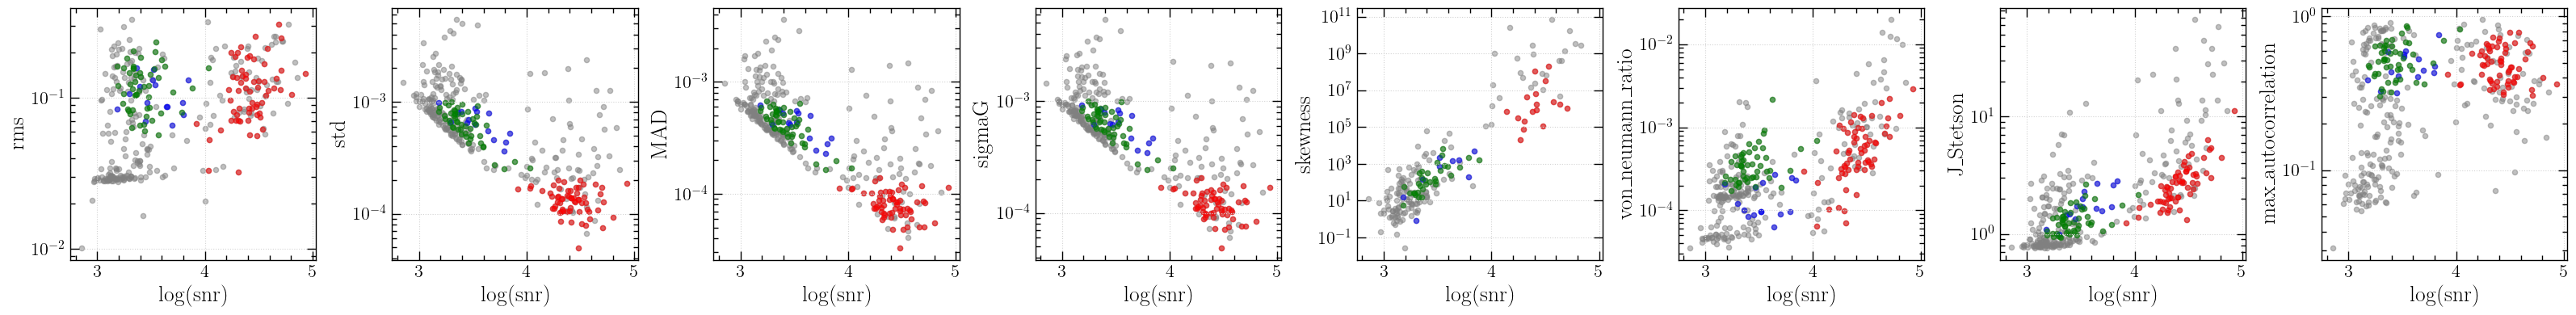

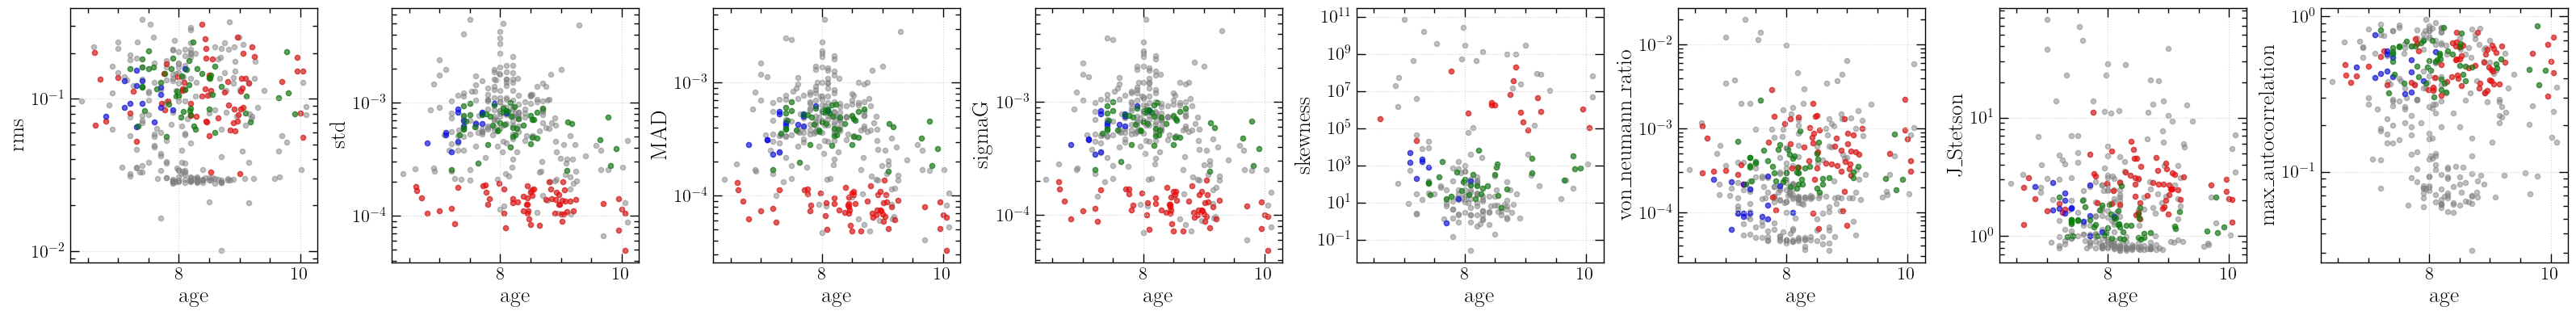

In [39]:
stats = ['rms','std','MAD','sigmaG','skewness','von_neumann_ratio','J_Stetson','max_autocorrelation']

#snr
col = 0
fig,ax = plt.subplots(1,8,figsize=(32,4))
for i in stats:
    ax[col].scatter(cluster_summary_stats['snr_50'],cluster_summary_stats['{}_50'.format(i)],s=20,c='grey',alpha=0.5)
    ax[col].scatter(mw_gold['snr_50'],mw_gold['{}_50'.format(i)],s=20,c='red',alpha=0.5,label='MW')
    ax[col].scatter(lmc_gold['snr_50'],lmc_gold['{}_50'.format(i)],s=20,c='blue',alpha=0.5,label='SMC')
    ax[col].scatter(smc_gold['snr_50'],smc_gold['{}_50'.format(i)],s=20,c='green',alpha=0.5,label='LMC')
    ax[col].set_yscale('log')
    ax[col].set_ylabel(i,fontsize=20)
    ax[col].set_xlabel('log(snr)',fontsize=20)
    col +=1
plt.tight_layout()

#age
col = 0
fig,ax = plt.subplots(1,8,figsize=(32,4))
for i in stats:
    ax[col].scatter(cluster_summary_stats['age'],cluster_summary_stats['{}_50'.format(i)],s=20,c='grey',alpha=0.5)
    ax[col].scatter(mw_gold['age'],mw_gold['{}_50'.format(i)],s=20,c='red',alpha=0.5,label='MW')
    ax[col].scatter(lmc_gold['age'],lmc_gold['{}_50'.format(i)],s=20,c='blue',alpha=0.5,label='SMC')
    ax[col].scatter(smc_gold['age'],smc_gold['{}_50'.format(i)],s=20,c='green',alpha=0.5,label='LMC')
    ax[col].set_yscale('log')
    ax[col].set_ylabel(i,fontsize=20)
    ax[col].set_xlabel('age',fontsize=20)
    col +=1
plt.tight_layout()

In [41]:
gold_sample.write('gold_cluster_sample_stats.fits')